**MULTI CLASSIFICATION WITH PYTORCH**

*DATASETS : sklearn.datasets.make_blobs*

In [57]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
N_SAMPLES = 1000
N_FEATURES = 2
N_CLASS = 4

x,y = make_blobs(n_samples=N_SAMPLES,
                 n_features=N_FEATURES,
                 centers=N_CLASS,
                 cluster_std=1.8)

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

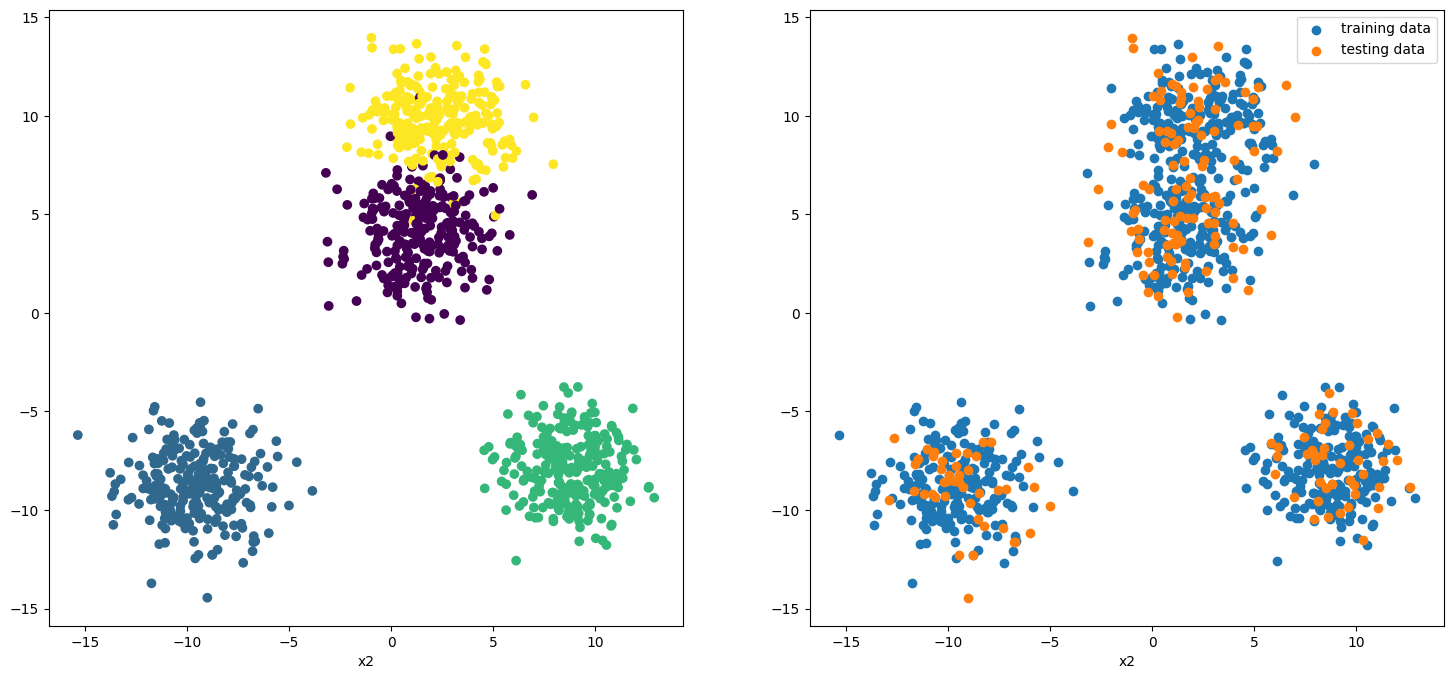

In [59]:
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
plt.scatter(x[:,0],x[:,1],c=y)
plt.xlabel("x1")
plt.xlabel("x2")

plt.subplot(1, 2, 2)
plt.scatter(x_train[:,0],x_train[:,1],label="training data")
plt.scatter(x_test[:,0],x_test[:,1],label="testing data")
plt.xlabel("x1")
plt.xlabel("x2")
plt.legend()
plt.show()

In [60]:
class MultiClassificationModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2,out_features=8)
        self.linear2 = nn.Linear(in_features=8,out_features=8)
        self.linear3 = nn.Linear(in_features=8,out_features=8)
        self.linear4 = nn.Linear(in_features=8,out_features=4)
        self.relu = nn.ReLU()

    def forward(self,x:torch.Tensor) -> torch.Tensor :
        layer1 = self.linear1(x)
        layer2 = self.linear2(self.relu(layer1))
        layer3 = self.linear3(self.relu(layer2))
        layer4 = self.linear4(self.relu(layer3))
        return layer4

class MultiClassificationModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2,out_features=8)
        self.linear2 = nn.Linear(in_features=8,out_features=8)
        self.linear3 = nn.Linear(in_features=8,out_features=8)
        self.linear4 = nn.Linear(in_features=8,out_features=4)

    def forward(self,x:torch.Tensor) -> torch.Tensor :
        layer1 = self.linear1(x)
        layer2 = self.linear2(layer1)
        layer3 = self.linear3(layer2)
        layer4 = self.linear4(layer3)
        return layer4

In [61]:
model = MultiClassificationModelV0()
print(model)

MultiClassificationModelV0(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=8, bias=True)
  (linear4): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)


In [62]:
def accuracy_fn(y_pred,y_true):
    correct = torch.eq(y_pred,y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [63]:
model.eval()
with torch.inference_mode():
    y_pred_test = model(x_test)
    print("Shape of y pred test",y_pred_test.shape)
    y_pred_label = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
    print("Shape of y pred label",y_pred_label.shape)
    print(f"Accuracy when not learning: {accuracy_fn(y_pred_label,y_test)}%")

Shape of y pred test torch.Size([200, 4])
Shape of y pred label torch.Size([200])
Accuracy when not learning: 33.5%


In [64]:
lossCross = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model.parameters(),lr=0.08)

In [65]:
EPOCHS = 3000
epoch_list = []
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []

for epoch in range(EPOCHS):
    # training
    model.train()

    y_pred_train = model(x_train)
    loss_train = lossCross(y_pred_train,y_train)

    y_pred_label_train = torch.argmax(torch.softmax(y_pred_train,dim=1),dim=1)
    acc_train = accuracy_fn(y_pred_label_train,y_train)

    opt.zero_grad()
    loss_train.backward()
    opt.step()

    # evaluting
    model.eval()
    with torch.inference_mode():
        y_pred_test = model(x_test).type(torch.float)
        loss_test = lossCross(y_pred_test,y_test)

        y_pred_label_test = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
        acc_test = accuracy_fn(y_pred_label_test,y_test)

        if epoch % 150 == 0:
            print(f"Epoch {epoch}#")
            print(f"Loss train : {loss_train}, Accuracy train : {acc_train}%")
            print(f"Loss test : {loss_test}, Accuracy test : {acc_test}%")

            epoch_list.append(epoch)
            loss_train_list.append(loss_train.detach().numpy())
            loss_test_list.append(loss_test.detach().numpy())
            acc_train_list.append(acc_train)
            acc_test_list.append(acc_test)

Epoch 0#
Loss train : 1.3517979383468628, Accuracy train : 33.5%
Loss test : 1.2685291767120361, Accuracy test : 43.5%
Epoch 150#
Loss train : 0.17486612498760223, Accuracy train : 91.375%
Loss test : 0.19657395780086517, Accuracy test : 96.5%
Epoch 300#
Loss train : 0.0929969772696495, Accuracy train : 96.0%
Loss test : 0.1274421513080597, Accuracy test : 95.5%
Epoch 450#
Loss train : 0.06797804683446884, Accuracy train : 97.375%
Loss test : 0.12118904292583466, Accuracy test : 95.5%
Epoch 600#
Loss train : 0.05943415313959122, Accuracy train : 98.0%
Loss test : 0.12394264340400696, Accuracy test : 95.5%
Epoch 750#
Loss train : 0.05539510399103165, Accuracy train : 98.0%
Loss test : 0.12715741991996765, Accuracy test : 95.5%
Epoch 900#
Loss train : 0.0530557744204998, Accuracy train : 98.125%
Loss test : 0.12835191190242767, Accuracy test : 96.0%
Epoch 1050#
Loss train : 0.051702775061130524, Accuracy train : 98.25%
Loss test : 0.12846995890140533, Accuracy test : 96.0%
Epoch 1200#
Lo

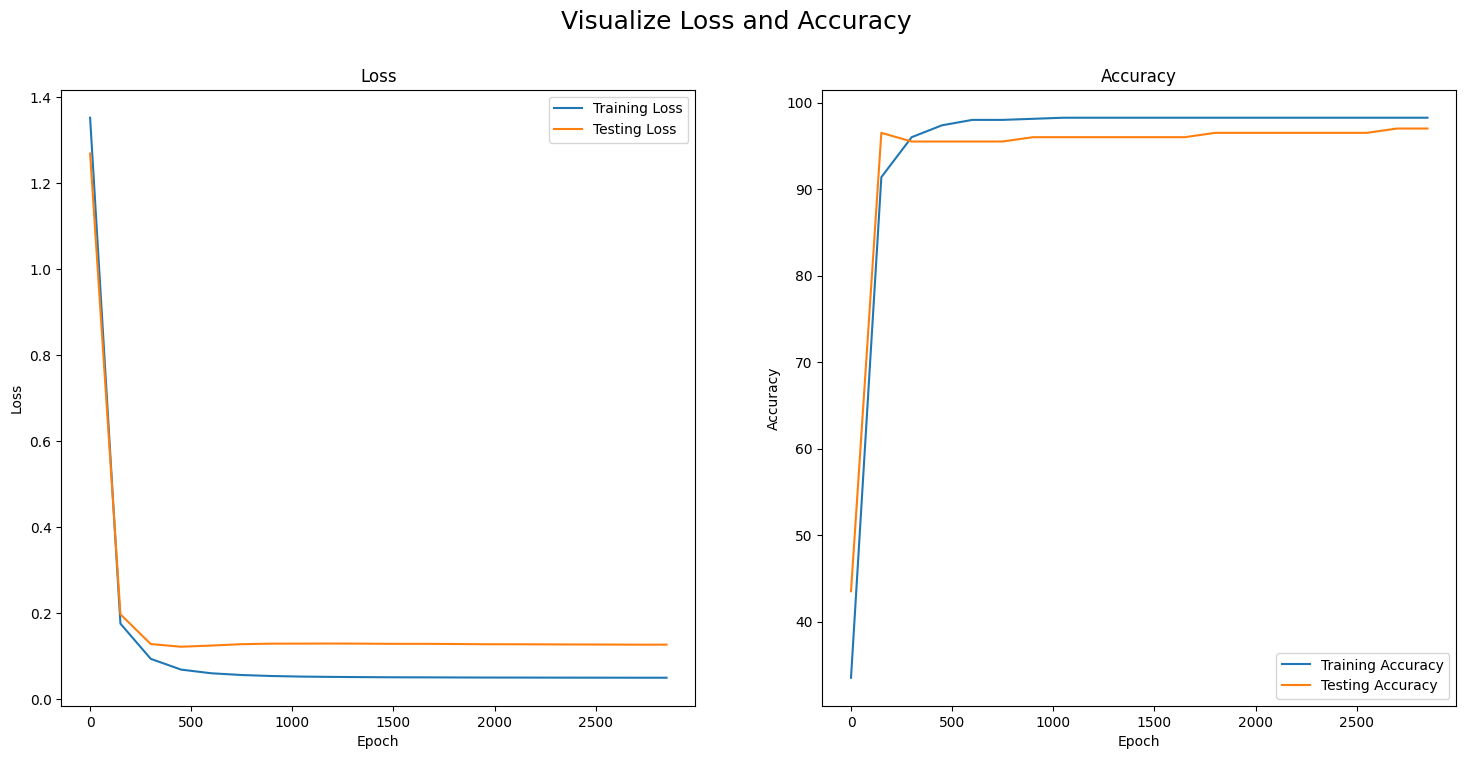

In [66]:
plt.figure(figsize=(18,8))
plt.suptitle("Visualize Loss and Accuracy", fontsize=18)

plt.subplot(1,2,1)
plt.plot(epoch_list,loss_train_list,label="Training Loss")
plt.plot(epoch_list,loss_test_list,label="Testing Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_list,acc_train_list,label="Training Accuracy")
plt.plot(epoch_list,acc_test_list,label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

helper_functions.py already exists, skipping download


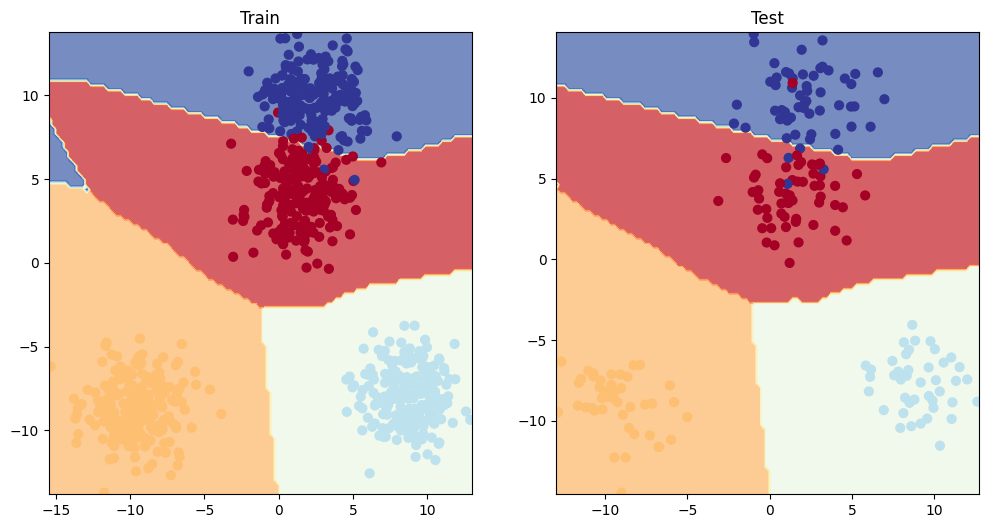

In [67]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)

In [68]:
model.eval()
with torch.inference_mode():
    y_pred_test = model(x_test)
    print("Shape of y pred test",y_pred_test.shape)
    y_pred_label = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
    print(y_pred_label[:10])
    print(y_test[:10])

Shape of y pred test torch.Size([200, 4])
tensor([0, 1, 2, 2, 0, 1, 1, 2, 0, 3])
tensor([0, 1, 2, 2, 0, 1, 1, 2, 0, 3])


In [69]:
try :
    import torchmetrics as tm
except:
    ! pip install torchmetrics
    import torchmetrics as tm

In [71]:
from torchmetrics.classification import confusion_matrix
model.eval()
with torch.inference_mode():
    # y_pred_test = model(x_test)
    # print("Shape of y pred test",y_pred_test.shape)
    y_pred_label = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
    accuracy = tm.Accuracy(task="multiclass", num_classes=4)
    precision = tm.Precision(task="multiclass", num_classes=4)
    recall = tm.Recall(task="multiclass", num_classes=4)
    f1Score = tm.F1Score(task="multiclass", num_classes=4)
    confusion_matrix = tm.ConfusionMatrix(task="multiclass", num_classes=4)
    print(f"Accuracy : {accuracy(y_pred_label, y_test)}")
    print(f"Precision : {precision(y_pred_label, y_test)}")
    print(f"Recall : {recall(y_pred_label, y_test)}")
    print(f"F1Score : {f1Score(y_pred_label, y_test)}")
    print(f"Confusion Matrix : {confusion_matrix(y_pred_label, y_test)}")
    print(y_pred_label[:10])
    print(y_test[:10])

Accuracy : 0.9750000238418579
Precision : 0.9750000238418579
Recall : 0.9750000238418579
F1Score : 0.9750000238418579
Confusion Matrix : tensor([[56,  0,  0,  1],
        [ 0, 44,  0,  0],
        [ 0,  0, 43,  0],
        [ 4,  0,  0, 52]])
tensor([0, 1, 2, 2, 0, 1, 1, 2, 0, 3])
tensor([0, 1, 2, 2, 0, 1, 1, 2, 0, 3])


In [72]:
from pathlib import Path 

MODEL = Path("model")
MODEL.mkdir(parents=True,exist_ok=True)
MODEL_NAME= "make_blobs_multi_classification_model.pth"
MODEL_PATH = MODEL / MODEL_NAME

torch.save(obj=model.state_dict(),f=MODEL_PATH)